In [47]:
import warnings
warnings.filterwarnings("ignore")
import os
import glob,re
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
# from mpi4py import MPI

In [48]:
# define functions
def load_and_process_file(file_path):
    """Efficiently load and process a single data file"""
    with Dataset(file_path, 'r') as file_model:
        # Load time data and convert to datetime
        time_model = file_model.variables['track_time'][:]
        masked_time = np.ma.masked_invalid(time_model)
        time_model = nc.num2date(masked_time,
                                file_model.variables['track_time'].units,
                                only_use_cftime_datetimes=False,
                                only_use_python_datetimes=True)
        
        # Extract lat/lon data for first position only (more efficient)
        lat_model = file_model.variables['track_lat'][:,0]
        lon_model = file_model.variables['track_lon'][:,0]
    
    # Create years array efficiently
    years = np.array([t[0].year for t in time_model])
    
    # Create DataFrame once with all data
    df = pd.DataFrame({
        'years': years,
        'lat': lat_model,
        'lon': lon_model
    })
    
    # Filter for Western Pacific basin
    mask = (df['lat'].between(5, 60)) & (df['lon'].between(100, 180))
    filtered_df = df[mask]
    
    # Get yearly counts
    return filtered_df['years'].value_counts().sort_index()



def process_files(file_pattern):
    """Process all matching files and return combined results"""
    files = glob.glob(file_pattern)
    all_counts = {}
    
    for file in files:
        counts = load_and_process_file(file)
        all_counts[file] = counts
    
    return pd.DataFrame(all_counts)


In [49]:
# When calculating probability distribution:
def calculate_probability_distribution(counts, bins):
    """Calculate probability distribution with improved binning"""
    # Flatten all counts
    all_counts = np.concatenate([counts[col].dropna().values for col in counts.columns])  
    # Calculate histogram and probability
    hist, bin_edges = np.histogram(all_counts, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, hist

In [50]:
file= Dataset('./Dataset/IBTrACS.WP.v04r01.nc', 'r')
print(file.variables.keys())
time = file.variables['time'][:]
d_times=nc.num2date(file.variables['time'][:],file.variables['time'].units
                    ,only_use_cftime_datetimes=False,only_use_python_datetimes=True)
sid=file.variables['sid'][:]
number=file.variables['number'][:]
numobs=file.variables['numobs'][:]
season=file.variables['season'][:]
basins = file.variables['basin'][:]
lat=file.variables['lat'][:]
lon=file.variables['lon'][:]
file.close()

dict_keys(['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma', 'source_hko', 'source_kma', 'source_new', 'source_reu', 'source_bom', 'source_nad', 'source_wel', 'source_td5', 'source_td6', 'source_ds8', 'source_neu', 'source_mlc', 'time', 'iso_time', 'nature', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'wmo_agency', 'track_type', 'main_track_sid', 'dist2land', 'landfall', 'iflag', 'usa_agency', 'usa_atcf_id', 'usa_lat', 'usa_lon', 'usa_record', 'usa_status', 'usa_wind', 'usa_pres', 'usa_sshs', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_poci', 'usa_roci', 'usa_rmw', 'usa_eye', 'tokyo_lat', 'tokyo_lon', 'tokyo_grade', 'tokyo_wind', 'tokyo_pres', 'tokyo_r50_dir', 'tokyo_r50_long', 'tokyo_r50_short', 'tokyo_r30_dir', 'tokyo_r30_long', 'tokyo_r30_short', 'tokyo_land', 'cma_lat', 'cma_lon', 'cma_cat', 'cma_wind', 'cma_pres', 'hko_lat', 'hko_lon', 'hko_cat', 'hko_wind', 'hko_pres', 'kma_lat', 'kma_lon', 'kma_cat', 'kma_wind', 'kma_pres', 'kma_r50_

In [51]:
file_current = Dataset('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m001.nc', 'r')
print(file_current.variables.keys())# show all variables of the model data

dict_keys(['track_time', 'track_lat', 'track_lon', 'track_pres', 'track_wind'])


Western Pacific (WP) locations: 5–60°N 100°–180°E

In [52]:
# filter the data with lat and lon
df_obs = pd.DataFrame({
    'years': season,
    'lat': lat[:,0],
    'lon': lon[:,0]
})
mask = (df_obs['lat'].between(5, 60)) & (df_obs['lon'].between(100, 180))
df_obs = df_obs[mask]

In [53]:
count_obs_series=pd.Series(df_obs['years']).value_counts().sort_index()
count_obs=pd.DataFrame(count_obs_series,columns=['count'])

In [54]:
count_current1 = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m001.nc') #process single current file

In [55]:
count_4K1 = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HFB_4K_CC_m105.nc') #process single 4K file

In [56]:
all_data_current = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m*.nc') #process all current files

In [57]:
all_data_4k = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HFB_4K*.nc') #process all 4K files

In [58]:
bins_obs, prob_obs = calculate_probability_distribution(count_obs,10)
bins_current1, prob_current1 = calculate_probability_distribution(count_current1,10)
bins_current_all, prob_current_all = calculate_probability_distribution(all_data_current,15)

In [59]:
bins_4K1, prob_4K1 = calculate_probability_distribution(count_4K1,8)

In [60]:
bins_4K_all, prob_4K_all = calculate_probability_distribution(all_data_4k,15)

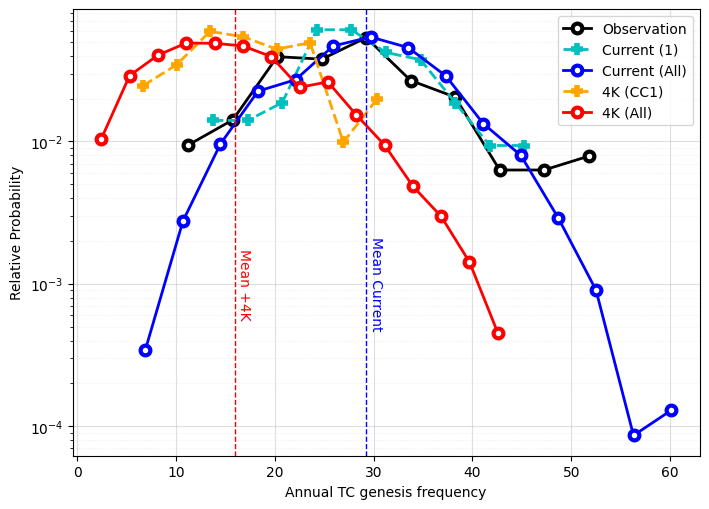

In [61]:
plt.figure(figsize=(7,5))
plt.semilogy(bins_obs, prob_obs, color='black', 
        linewidth=2, marker='o', markersize=7, 
        markerfacecolor='white',
        markeredgecolor='black',
        markeredgewidth=3,
        label='Observation')

plt.semilogy(bins_current1, prob_current1, 
            'c--',linewidth=2, marker='+', markeredgewidth=4,
            markersize=8, label='Current (1)')
plt.semilogy(bins_current_all, prob_current_all,color='blue', 
        linewidth=2, marker='o', markersize=7, 
        markerfacecolor='white',
        markeredgecolor='blue',
        markeredgewidth=3,
        label='Current (All)')
plt.semilogy(bins_4K1, prob_4K1, 
            '--',color='orange',linewidth=2, marker='+', markeredgewidth=4,
            markersize=8, label='4K (CC1)')
plt.semilogy(bins_4K_all, prob_4K_all,color='red',
        linewidth=2, marker='o', markersize=7, 
        markerfacecolor='white',
        markeredgecolor='red',
        markeredgewidth=3,
        label='4K (All)')

# plot mean vertical line
plt.axvline(all_data_current.mean().mean(), color='blue', linestyle='--', linewidth=1)
plt.text(29.5, 0.001, 'Mean Current', 
         rotation=-90,
         color='blue',
         verticalalignment='center')
plt.axvline(all_data_4k.mean().mean(), color='red', linestyle='--', linewidth=1)
plt.text(16.2, 0.001, 'Mean +4K', 
         rotation=-90,
         color='red',
         verticalalignment='center')
# Configure grid
plt.grid(True, which='major', linestyle='-', alpha=0.4)
plt.grid(True, which='minor', linestyle=':', alpha=0.2)
plt.tight_layout()
plt.xlabel('Annual TC genesis frequency')
plt.ylabel('Relative Probability')
plt.legend()

In [ ]:
def plot_tc_genesis(data_current, obs_data, region_name, ylim=(0,60)):
   # Calculate correlations
   r_all = np.corrcoef(obs_data.values, data_current.mean(axis=1).values)[0,1]
   r_each = np.mean([np.corrcoef(obs_data.values, data_current[col].values)[0,1] 
                     for col in data_current.columns])
   
   # Calculate percentiles for shading bands
   percentiles = [5, 10, 20, 35, 65, 80, 90, 95]
   perc_curves = np.percentile(data_current, percentiles, axis=1)
   
   fig, ax = plt.subplots(figsize=(10, 4))
   
   # Plot gray shaded percentile bands
   for i in range(len(percentiles)-1):
       ax.fill_between(data_current.index, 
                      perc_curves[i], 
                      perc_curves[i+1],
                      color='gray',
                      alpha=0.2)
   
   # Plot ensemble mean and observations
   mean_line = ax.plot(data_current.index, data_current.mean(axis=1), 
                      'g-', linewidth=1.5)
   obs_line = ax.plot(obs_data.index, obs_data.values, 
                     'r-', linewidth=1.5)
   
   # Statistical significance (squares)
   p10 = pd.Series(np.percentile(data_current, 10, axis=1), index=data_current.index)
   p90 = pd.Series(np.percentile(data_current, 90, axis=1), index=data_current.index)
   for year in data_current.index:
       if obs_data[year] > p90[year] or obs_data[year] < p10[year]:
           ax.plot(year, obs_data[year], 's', color='red', markersize=6)
   
   # End triangles for climatological means
   last_year = data_current.index[-1]
   ax.plot(last_year+0.5, obs_data.mean(), '>', color='red', markersize=8)
   ax.plot(last_year+0.5, data_current.mean().mean(), '>', color='green', markersize=8)
   
   # Styling
   ax.set_ylim(ylim)
   ax.grid(True, linestyle=':', alpha=0.6)
   ax.set_title(f"{region_name} [R_ALL={r_all:.2f}, R_EACH={r_each:.2f}]")
   ax.set_xlabel('[YEAR]')
   ax.set_ylabel('[TC number]')
   
   return fig, ax

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Western Pacific Basin [R_ALL=0.27, R_EACH=0.19]'}, xlabel='[YEAR]', ylabel='[TC number]'>)

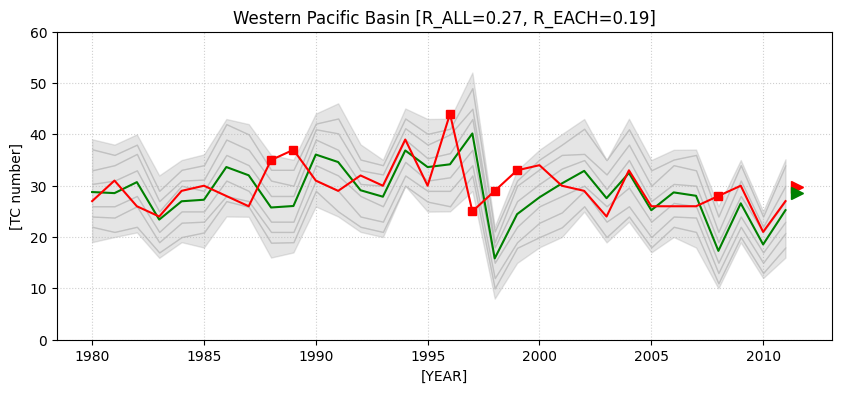

In [95]:
plot_tc_genesis(all_data_current.loc[1980:2011], count_obs_series.loc[1980:2011], 'Western Pacific Basin')